In [1]:
import numpy as np
from scipy.integrate import solve_bvp
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib import animation
import matplotlib.image as mpimg
from scipy.ndimage import rotate
from itertools import product
from tqdm import tqdm

from utils import lunar_lander, make_plots, make_control_plot, make_trajectory_plot

animation.writer = animation.writers['ffmpeg']

In [2]:
def lunar_lander_fixed_target(pos_init, pos_final, v_init, tf_guess=20, y0_guess=1, alpha=10., beta=25., gamma=3., nu=0., G=2., t_steps=200, animate_file=None):
    '''Find the optimal control and trajectory for the lunar lander.

        Parameters:
            pos_init (tuple) : x and y coordinates defining the starting position of the lunar lander
            v_init (float) : the lander's starting velocity in the x direction
            alpha (float) : the weight on the magnitude of the lander's acceleration over time
            beta (float) : the weight on the magnitude of the lander's final velocity (both x and y directions)
            gamma (float) : the weight on the final time
            nu (float): the weight of the y_position being negative
            G (float) : acceleration due to gravity on the moon
            t_steps : number of time steps to evaluate
            animate_file : if a string filename is passed in, an animation will be created and saved in the 
                specified file name. If no filename is passed in, the function will return without creating an
                animation
        
        Returns: 
            t_vals (ndarray) : the time values corresponding with the solution values
            x (ndarray) : the lander's trajectory (position) in the x direction
            y (ndarray) : the lander's trajectory (position) in the y direction
            xp (ndarray) : the lander's velocity in the x direction
            yp (ndarray) : the lander's velocity in the y direction
            ux (ndarray) : the optimal control (acceleration) in the x direction
            uy (ndarray) : the optimal control (acceleration) in the y direction
            tf (float) : the optimal landing time
    '''

    x_init, y_init = pos_init
    x_final, y_final = pos_final

    # Define the ODE's associated with state and costate evolution
    def ode(t, y, p):
        tf = p[0]
        return tf * np.array([
            y[2],
            y[3],
            y[6] / (2*alpha),
            y[7] / (2*alpha) - G,
            np.zeros_like(y[0]), 
            nu*(1-np.heaviside(y[1], 0)), 
            -y[4],
            -y[5]
        ])
    
    # Define the boundary conditions
    # BC's 1-5 come from known initial and final conditions
    # BC's 6-8 come from conditions on the costate
    # BC 9 comes from the final condition on the Hamiltonian relating to variable final time
    def bc(ya, yb, p):
        tf = p[0]
        uxf = yb[6] / (2*alpha)
        uyf = yb[7] / (2*alpha)
        return np.array([
            ya[0] - x_init,
            ya[1] - y_init,
            ya[2] - v_init,
            ya[3],
            yb[0] - x_final,
            yb[1] - y_final,
            yb[6] - 2*beta*yb[2],
            yb[7] - 2*beta*yb[3],
            yb[4]*yb[2] + yb[5]*yb[3] + yb[6]*uxf + yb[7]*(uyf - G) - alpha*(uxf**2 + uyf**2) - gamma + nu*(np.minimum(0, yb[1]))
        ])
    
    # Define the initial guess
    tf_0 = tf_guess
    t_eval = np.linspace(0, 1, t_steps) 
    y0 = y0_guess * np.ones((8, t_steps))
    y0[0] = np.ones((1, t_steps))


    y0[0] = np.linspace(x_init, x_final, t_steps)   # x and y move from starting to 
    y0[1] = np.linspace(y_init, y_final, t_steps)   # ending positions
    y0[2] = np.linspace(v_init, 0, t_steps)         # vx goes to 0
    

    # Solve the ODE
    sol = solve_bvp(ode, bc, t_eval, y0, p=np.array([tf_0]), max_nodes=30000)
    tf = sol.p[0]

    # Extract the different elements of the solution
    x = sol.y[0]
    y = sol.y[1]
    xp = sol.y[2]
    yp = sol.y[3]
    ux = sol.y[6] / (2*alpha)       # compute controls from costates
    uy = sol.y[7] / (2*alpha)
    t_vals = sol.x * tf

    return t_vals, x, y, xp, yp, ux, uy-G, tf

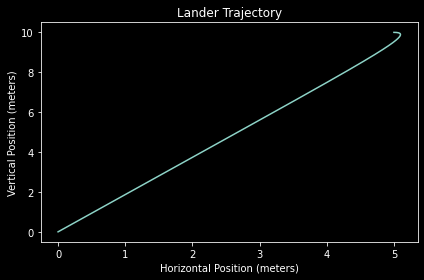

Final Time: 0.6861566358127276
Final Position: (-0.0, 0.0)


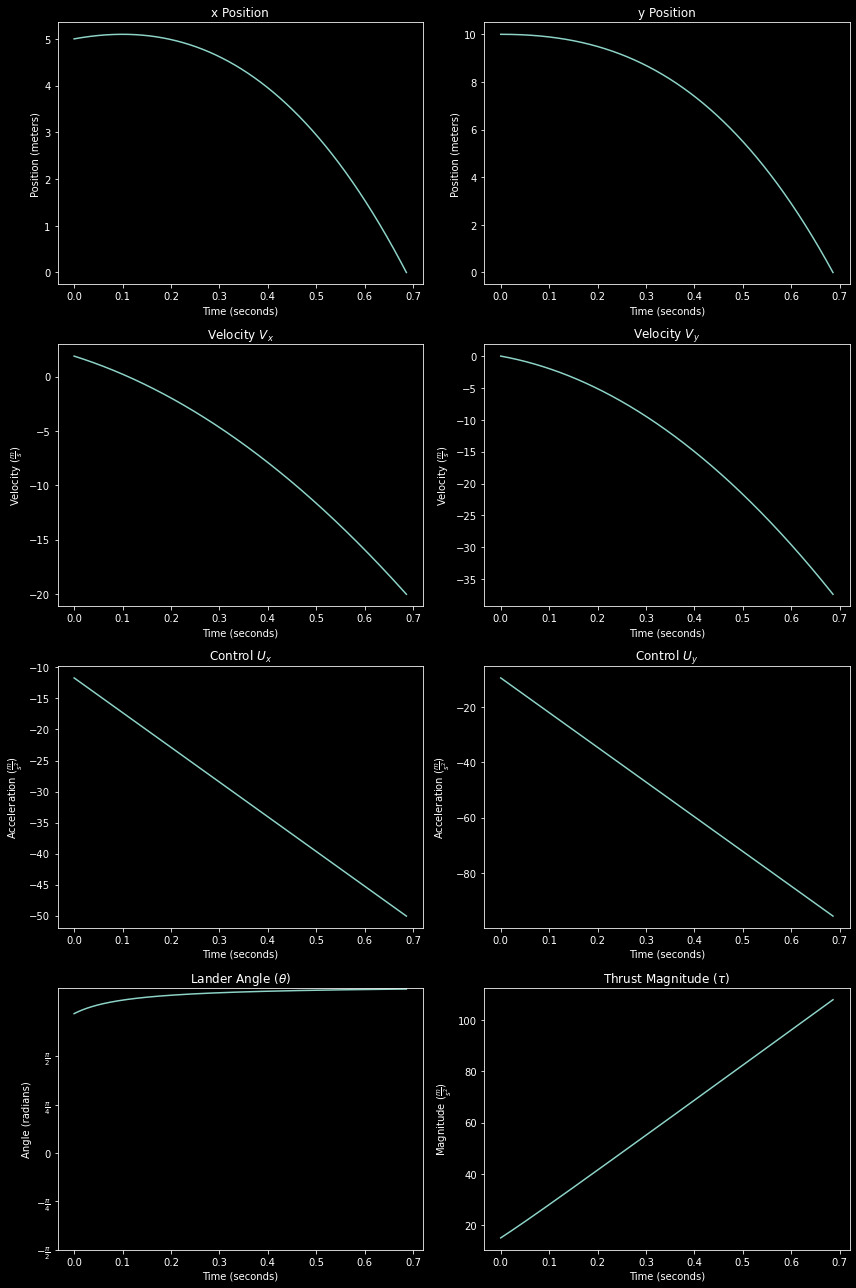

In [3]:
pos_init = (5., 10.)
pos_final = (0., 0.)
v = 1.88

t, x, y, xp, yp, ux, uy, tf = lunar_lander_fixed_target(pos_init, pos_final, v)

make_trajectory_plot(x, y)
make_plots(t, x, y, xp, yp, ux, uy, tf)

In [4]:
class Obstacle:

    def __init__(self, r=(1., 1.), c=(0., 0.), lam=1.):
        self.r = r 
        self.c = c
        self.lam = lam

    def obstacle(self, x, y):
        ellipse = ((x - self.c[0])**2/self.r[0] + (y - self.c[1])**2/self.r[1])**20 + 1

        return self.lam / ellipse
    
    def obstacle_dx(self, x, y):
        circle = (x - self.c[0])**2/self.r[0] + (y - self.c[1])**2/self.r[1]
        numer = -40 * self.lam * (x-self.c[0])*(circle)**19
        denom = self.r[0]*((circle)**20 + 1)**2

        return numer / denom
    
    def obstacle_dy(self, x, y):
        circle = (x - self.c[0])**2/self.r[0] + (y - self.c[1])**2/self.r[1]
        numer = -40 * self.lam * (y-self.c[1])*(circle)**19
        denom = self.r[1]*((circle)**20 + 1)**2

        return numer / denom

In [5]:
def lunar_lander_obstacles(pos_init, v_init, obstacle, tf_guess=20, y0_guess=1, alpha=10., beta=25., gamma=3., nu=0., G=2., t_steps=200, animate_file=None):
    '''Find the optimal control and trajectory for the lunar lander.

        Parameters:
            pos_init (tuple) : x and y coordinates defining the starting position of the lunar lander
            v_init (float) : the lander's starting velocity in the x direction
            alpha (float) : the weight on the magnitude of the lander's acceleration over time
            beta (float) : the weight on the magnitude of the lander's final velocity (both x and y directions)
            gamma (float) : the weight on the final time
            nu (float): the weight of the y_position being negative
            G (float) : acceleration due to gravity on the moon
            t_steps : number of time steps to evaluate
            animate_file : if a string filename is passed in, an animation will be created and saved in the 
                specified file name. If no filename is passed in, the function will return without creating an
                animation
        
        Returns: 
            t_vals (ndarray) : the time values corresponding with the solution values
            x (ndarray) : the lander's trajectory (position) in the x direction
            y (ndarray) : the lander's trajectory (position) in the y direction
            xp (ndarray) : the lander's velocity in the x direction
            yp (ndarray) : the lander's velocity in the y direction
            ux (ndarray) : the optimal control (acceleration) in the x direction
            uy (ndarray) : the optimal control (acceleration) in the y direction
            tf (float) : the optimal landing time
    '''

    x_init, y_init = pos_init

    # Define the ODE's associated with state and costate evolution
    def ode(t, y, p):
        tf = p[0]
        return tf * np.array([
            y[2],
            y[3],
            y[6] / (2*alpha),
            y[7] / (2*alpha) - G,
            obstacle.obstacle_dx(y[0], y[1]), 
            obstacle.obstacle_dy(y[0], y[1]) + nu*(1-np.heaviside(y[1], 0)), 
            -y[4],
            -y[5]
        ])
    
    # Define the boundary conditions
    # BC's 1-5 come from known initial and final conditions
    # BC's 6-8 come from conditions on the costate
    # BC 9 comes from the final condition on the Hamiltonian relating to variable final time
    def bc(ya, yb, p):
        tf = p[0]
        uxf = yb[6] / (2*alpha)
        uyf = yb[7] / (2*alpha)
        return np.array([
            ya[0] - x_init,
            ya[1] - y_init,
            ya[2] - v_init,
            ya[3],
            yb[1],
            yb[4],
            yb[6] - 2*beta*yb[2],
            yb[7] - 2*beta*yb[3],
            yb[4]*yb[2] + yb[5]*yb[3] + yb[6]*uxf + yb[7]*(uyf - G) - alpha*(uxf**2 + uyf**2) - gamma + nu*(np.minimum(0, yb[1])) - obstacle.obstacle(yb[0], yb[1])
        ])
    
    # Define the initial guess
    tf_0 = tf_guess
    t_eval = np.linspace(0, 1, t_steps) 
    y0 = y0_guess * np.ones((8, t_steps))
    y0[0] = np.ones((1, t_steps))


    # y0[0] *= x_init                            # x constant
    y0[0] = x_init + v * t_eval
    y0[1] = np.linspace(y_init, 0, t_steps)    # y goes to 0
    y0[2] = np.linspace(v_init, 0, t_steps)    # vx goes to 0
    

    # Solve the ODE
    sol = solve_bvp(ode, bc, t_eval, y0, p=np.array([tf_0]), max_nodes=30000)
    tf = sol.p[0]

    # Extract the different elements of the solution
    x = sol.y[0]
    y = sol.y[1]
    xp = sol.y[2]
    yp = sol.y[3]
    ux = sol.y[6] / (2*alpha)       # compute controls from costates
    uy = sol.y[7] / (2*alpha)
    t_vals = sol.x * tf

    return t_vals, x, y, xp, yp, ux, uy-G, tf

In [58]:
obstacle = Obstacle(r=(1., 3.), c=(3., 0.), lam=25.)
print(obstacle.obstacle_dy(3.5, 1.))

-0.011892680533913833


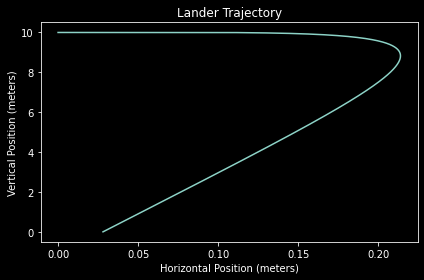

Final Time: 0.8266206593011168
Final Position: (0.028, -0.0)


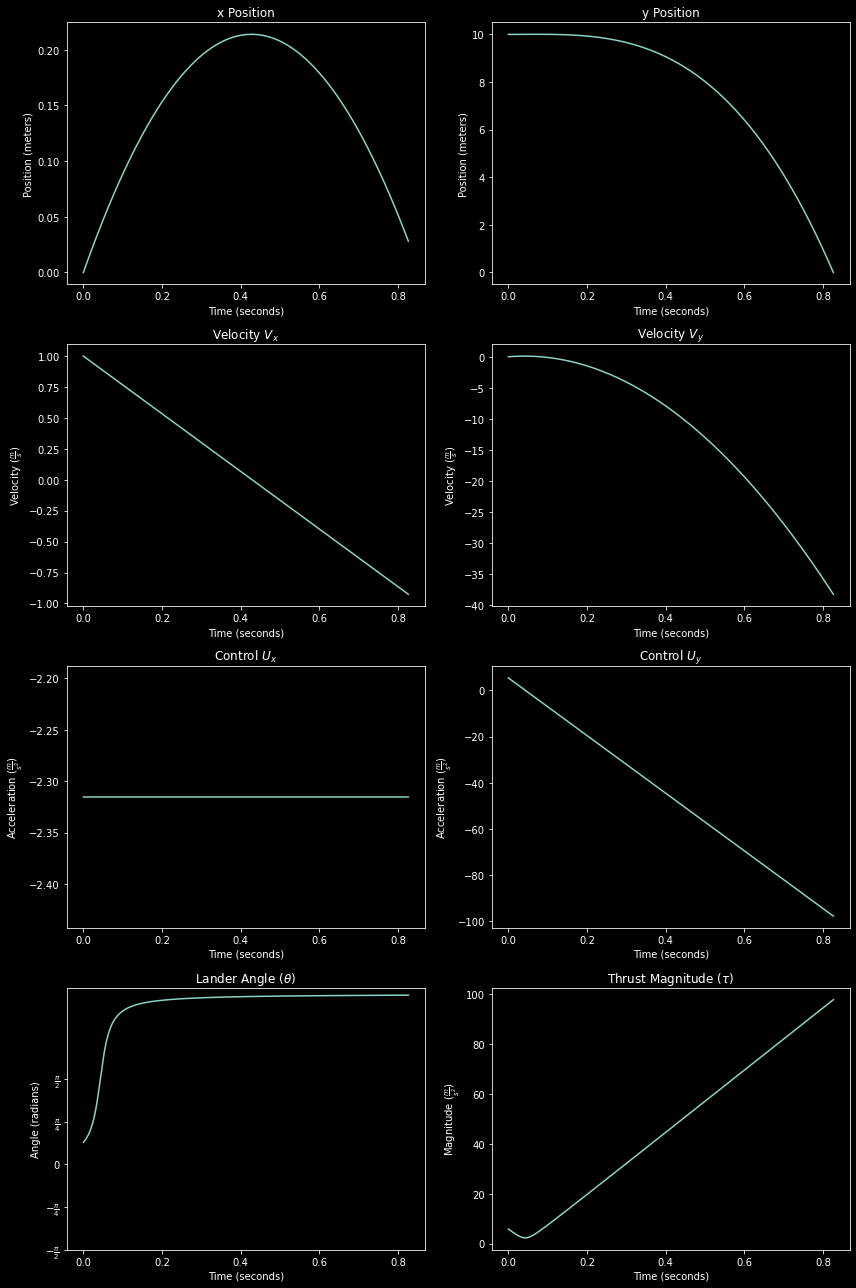

In [63]:
pos_init = (0., 10.)
v = 1.

t, x, y, xp, yp, ux, uy, tf = lunar_lander(pos_init, v, nu=40, alpha=10., beta=25., gamma=5.)
make_trajectory_plot(x, y)
make_plots(t, x, y, xp, yp, ux, uy, tf)

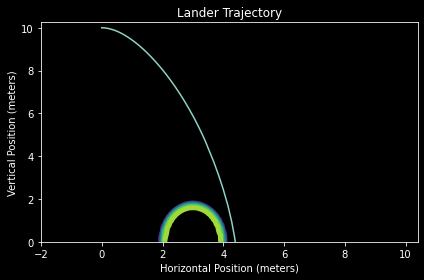

Final Time: 4.3146991371107095
Final Position: (4.395, -0.0)


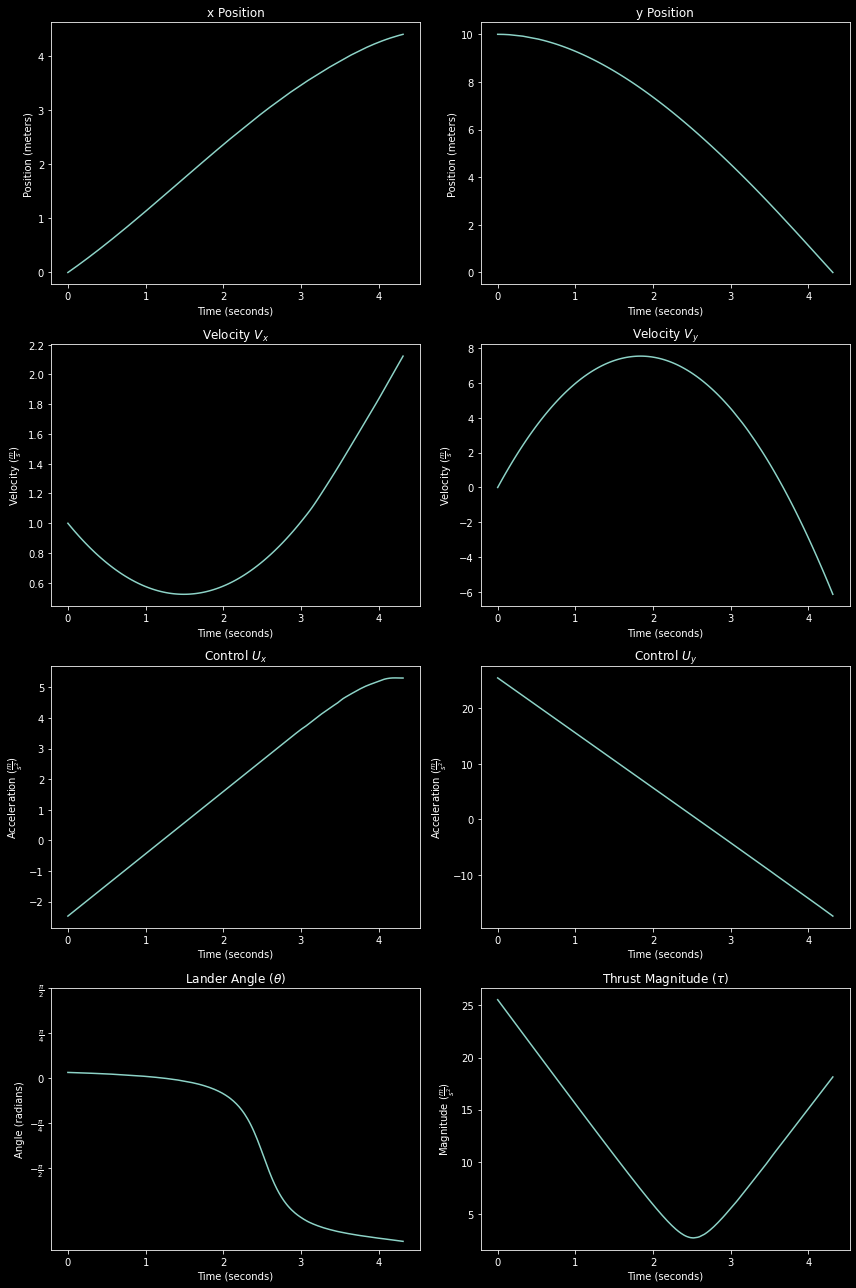

In [59]:
pos_init = (0., 10.)
v = 1.

t, x, y, xp, yp, ux, uy, tf = lunar_lander_obstacles(pos_init, v, obstacle, nu=40, alpha=10., beta=25., gamma=5.)


make_trajectory_plot(x, y, obstacle)
make_plots(t, x, y, xp, yp, ux, uy, tf)